In [13]:
from myclasses.sql_executor import SQLExecutor
import pandas as pd

if __name__ == "__main__":
    # Create an instance of SQLExecutor
    sql_executor = SQLExecutor()

    # Example SQL query
    query = """

        SELECT 
        
            a.prov_id,
            a.fiscal_year, 
            a.ownership,
            a.tot_days_title_tot as tot_days,
            a.num_beds,
            a.snf_num_beds,
            a.snf_admis_tot,
            a.snf_avg_stay_len_title_tot,
            a.snf_days_total,
            a.tot_discharge_tot,
            a.snf_discharge_tot,
            a.tot_salaries,
            a.overhead_nonsalary_costs,
            a.cash_on_hand_and_in_banks as cash,
            a.acct_rec,
            a.acct_payable,
            a.tot_current_assets,
            a.tot_fixed_assets,
            a.tot_assets,
            a.tot_liabilities,
            a.contract_labor,
            a.general_fund_balance,
            a.tot_fund_balance,
            a.wagerelated_costs,
            a.total_operating_expense,
            a.loc_type,
            a.buildings,
            a.current_ratio,
            a.employee_inpatient_revenue_ratio,
            d.num_scope as deficiency_score,
            i.overall_rating,
            i.resfamcouncil,
            i.sprinkler_status,
            i.chow_last_12mos,
            i.fine_cnt,
            i.fine_tot,
            i.tot_penlty_cnt,
            i.state,
            i.survey_rating,
            i.quality_rating,
            i.staffing_rating,
            i.rn_staffing_rating,
            i.aidhrd,
            i.vochrd,
            i.rnhrd,
            i.totlichrd,
            i.tothrd,
            i.pthrd,
            i.weighted_all_cycles_score,
            i.certification,
            i.bedcert,
            a.net_income

        FROM aggCostReports a

        LEFT JOIN (
                SELECT * FROM DeficiencyYear
            ) d ON a.prov_id = d.prov_id AND a.fiscal_year = d.report_year
            
        LEFT JOIN (
                SELECT * FROM ProviderInfo
            ) i ON a.prov_id = i.prov_id AND a.fiscal_year = LEFT(i.filedate,4);

        """

    # Execute the query and get the result as a DataFrame
    df = sql_executor.execute_query(query)

# Convert data type
df['weighted_all_cycles_score'] = pd.to_numeric(df['weighted_all_cycles_score'], errors='coerce')

# Assuming NA contract_labor/buildings means the Nursing home does have contract_labor/buildings
df[['buildings','contract_labor']] = df[['buildings','contract_labor']].fillna(0)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97654 entries, 0 to 97653
Data columns (total 52 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   prov_id                           97654 non-null  object 
 1   fiscal_year                       97654 non-null  int64  
 2   ownership                         97654 non-null  float64
 3   tot_days                          97644 non-null  float64
 4   num_beds                          97342 non-null  float64
 5   snf_num_beds                      97329 non-null  float64
 6   snf_admis_tot                     96837 non-null  float64
 7   snf_avg_stay_len_title_tot        97392 non-null  float64
 8   snf_days_total                    97638 non-null  float64
 9   tot_discharge_tot                 97403 non-null  float64
 10  snf_discharge_tot                 97393 non-null  float64
 11  tot_salaries                      97653 non-null  float64
 12  over

In [14]:
import numpy as np

# Drop observations where null in netincome
df = df.dropna(subset=['net_income','state'])

# Replace NaN values with median for numerical columns
numerical_columns = df.select_dtypes(include=['number']).columns
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].median())

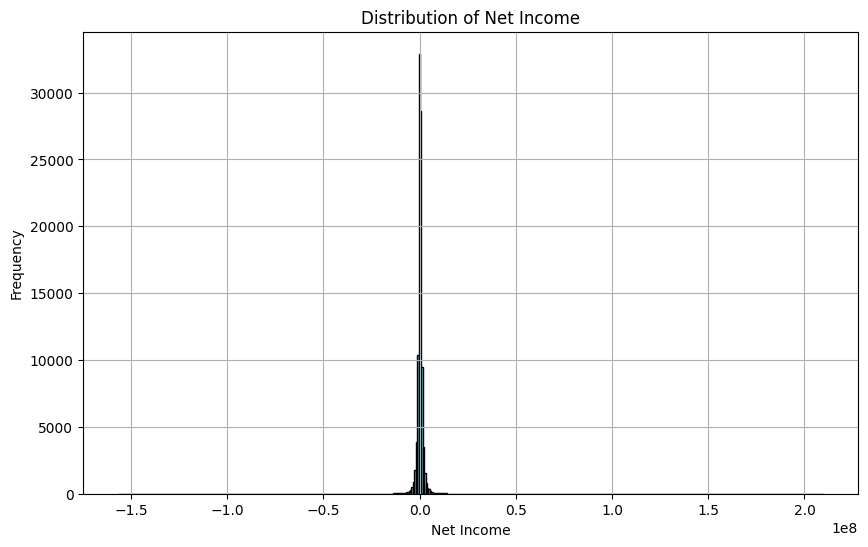

In [15]:
import matplotlib.pyplot as plt

# Assuming net_incomes is your net income data
plt.figure(figsize=(10, 6))
plt.hist(df['net_income'], bins=500, color='skyblue', edgecolor='black')
plt.title('Distribution of Net Income')
plt.xlabel('Net Income')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [16]:
df.shape

(97168, 52)

In [17]:
from sklearn.model_selection import train_test_split


# Separate features and target variable
X = df.drop(['net_income', 'prov_id', 'state'], axis=1)  # Drop 'prov_id' and 'net_income' columns
y = df['net_income']

# Set categorical columns for dummy variables
categorical_cols = list(X.select_dtypes(include=['object']).columns)
X = pd.get_dummies(X, columns = categorical_cols)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [18]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Define XGBoost regressor and set hyperparameters
xgb_model = xgb.XGBRegressor( 
    n_estimators=10000,        # Number of boosting rounds
    learning_rate=0.065,        # Step size shrinkage used in update to prevent overfitting
    device='cpu',             # Use GPU for training
    max_depth=7,               # Maximum depth of a tree
    min_child_weight=1,        # Minimum sum of instance weight (hessian) needed in a child
    subsample=0.85,            # Subsample ratio of the training instances
    colsample_bytree=0.95,     # Subsample ratio of columns when constructing each tree
    random_state=42,           # Seed for random number generator
    eval_metric='rmse',         # Evaluation metric
    early_stopping_rounds=100, # Number of rounds without improvement before stopping
    objective='reg:squarederror'     # Objective function for regression
)

# Train XGBoost model with progress printout and early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Evaluation set for tracking progress
)

# # Perform cross-validation
# cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', verbose = 2)

# # # Convert the scores to positive
# cv_scores = -cv_scores

# # Print the cross-validation scores
# print("Cross-Validation RMSE Scores:", cv_scores)

[0]	validation_0-rmse:2437558.23035	validation_1-rmse:2227907.54947
[1]	validation_0-rmse:2391213.86195	validation_1-rmse:2198606.84059
[2]	validation_0-rmse:2347674.21283	validation_1-rmse:2174255.25837
[3]	validation_0-rmse:2309810.56682	validation_1-rmse:2156782.74084
[4]	validation_0-rmse:2273587.26324	validation_1-rmse:2141020.96036
[5]	validation_0-rmse:2240143.91444	validation_1-rmse:2122981.40910
[6]	validation_0-rmse:2209595.84952	validation_1-rmse:2109433.84037
[7]	validation_0-rmse:2181957.25226	validation_1-rmse:2094686.98819
[8]	validation_0-rmse:2147571.45435	validation_1-rmse:2087556.99322
[9]	validation_0-rmse:2115578.41604	validation_1-rmse:2078126.91188
[10]	validation_0-rmse:2085767.49922	validation_1-rmse:2068091.71673
[11]	validation_0-rmse:2056756.01284	validation_1-rmse:2057611.84721
[12]	validation_0-rmse:2032233.93813	validation_1-rmse:2053529.26811
[13]	validation_0-rmse:2003047.89539	validation_1-rmse:2050430.84389
[14]	validation_0-rmse:1974153.50445	validat

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device='cpu', early_stopping_rounds=100,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.065, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [19]:
import numpy as np
from sklearn.metrics import r2_score, median_absolute_error, max_error, mean_absolute_error, mean_squared_error, explained_variance_score

# Predict on test set
y_pred = xgb_model.predict(X_test)

# R² Score (Coefficient of Determination)
r2 = r2_score(y_test, y_pred)

# Median Absolute Error
mae = median_absolute_error(y_test, y_pred)

# Max Error
max_error_value = max_error(y_test, y_pred)

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error
rmse = np.sqrt(mse)

# Explained Variance Score
explained_variance = explained_variance_score(y_test, y_pred)

# Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Root Mean Squared Error: ${:.2f}".format(rmse))
print("Median Absolute Error: ${:.2f}".format(mae))
print("Max Error: ${:.2f}".format(max_error_value))
print("R² Score (Coefficient of Determination): {:.5f}".format(r2))

Root Mean Squared Error: $1961918.80
Median Absolute Error: $723091.00
Max Error: $97804855.50
R² Score (Coefficient of Determination): 0.23980


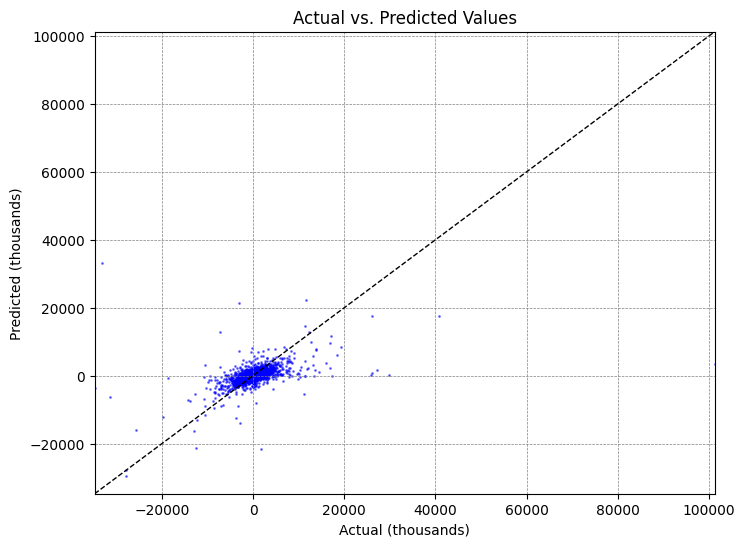

In [20]:
import matplotlib.pyplot as plt

# Convert values to thousands
y_test_thousands = y_test / 1000
y_pred_thousands = y_pred / 1000

plt.figure(figsize=(8, 6))
plt.scatter(y_test_thousands, y_pred_thousands, color='blue', alpha=0.5, s=1)  # Scatter plot of actual vs. predicted values with smaller point size
plt.plot([y_test_thousands.min(), y_test_thousands.max()], [y_test_thousands.min(), y_test_thousands.max()], 'k--', lw=1)  # Plot the diagonal line
plt.xlabel('Actual (thousands)')
plt.ylabel('Predicted (thousands)')
plt.title('Actual vs. Predicted Values')

# Set axis limits to show the actual values
plt.xlim(left=y_test_thousands.min(), right=y_test_thousands.max())
plt.ylim(bottom=y_test_thousands.min(), top=y_test_thousands.max())

# Add light gridlines
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.show()

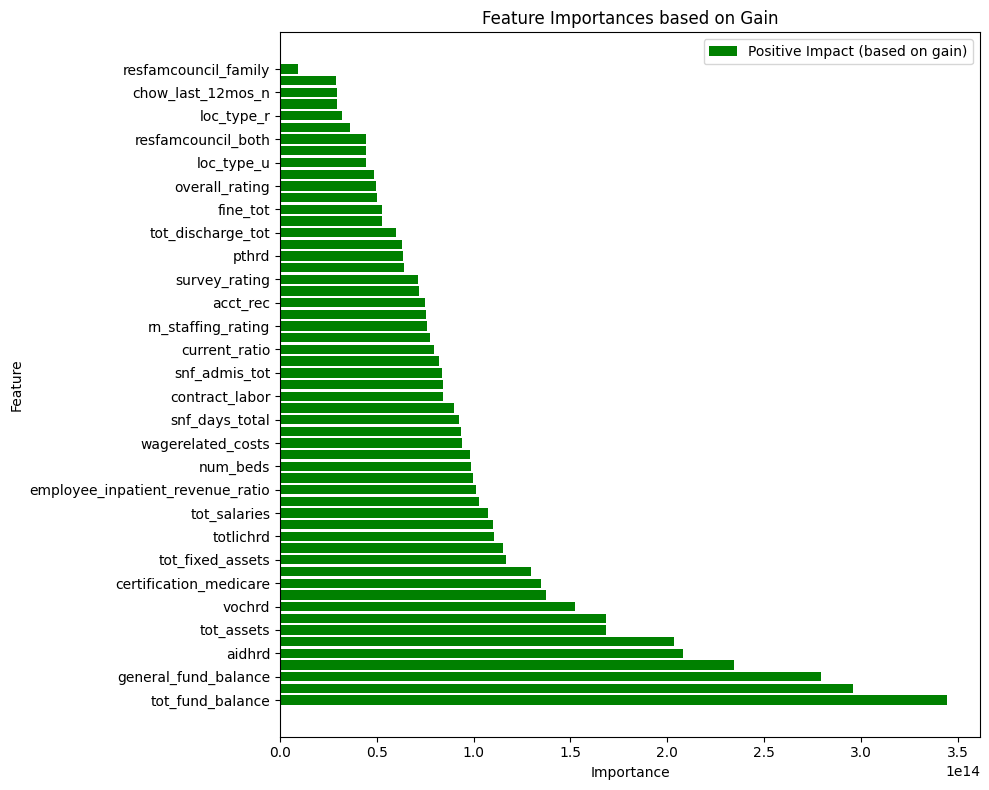

In [21]:
# Get feature importances based on gain
feature_importances_gain = xgb_model.get_booster().get_score(importance_type='gain')

# Sort the dictionary by importances in descending order
sorted_feature_importance_gain = sorted(feature_importances_gain.items(), key=lambda x: x[1], reverse=True)

# Separate positive and negative importances (since gain is inherently positive)
positive_importances_gain = dict(sorted_feature_importance_gain)

# Extract feature names and importances
positive_features_gain, positive_importances_gain = zip(*positive_importances_gain.items())

# Plot positive importances based on gain
plt.figure(figsize=(10, 8))
plt.barh(positive_features_gain, positive_importances_gain, color='green', label='Positive Impact (based on gain)')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances based on Gain')
plt.legend()

# Increase spacing between y-axis ticks by skipping every other tick
plt.yticks(range(0, len(positive_features_gain), 2), positive_features_gain[::2])  # Skip every other tick

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()